<a href="https://colab.research.google.com/github/beppe95/Text-Summarization/blob/master/Document_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Requirements
You only need to install `mpld3` which is a matplotlib wrapper for `D3.js`.

`mpld3` let's you use matplotlib syntax in order to create web interactives providing high-level API.


In [2]:
!pip install mpld3

     |████████████████████████████████| 798kB 2.8MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=095a3ac5fabfc3a1c5a6a522f5d0c93035eb7ad057daadf58cec33ab596944eb
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


## Notebook Overview
In this notebook I will use `TD-IDFVectorizer` and `MiniBatchKMeans` to perform some document clustering.

After that, we'll plot the obtained clusters using `Principal Component Analysis` and `T-Distributed Stochastic Neighbor Embedding`, then we'll show the most rated keyword inside each cluster.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Importing the dataset
We use Pandas to read our JSON file.

In [5]:
dataset = pd.read_json('../content/drive/My Drive/content/documents.json', lines=True)
dataset.head()

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]


## Keyword extraction
We use `TF-IDFVectorizer` in order to calculate IDF score to understand if through this method application we can pull out unique words to use inside our clustering task.

In the following code we:
* `min_df`: ignore each term that have a document frequency strictly lower than the given threshold
* `max_df`: ignore each term that have a document frequency strictly higher than the given threshold (corpus-specific stop words) 
* `max_features`: build a vocabulary that only consider the top max_features ordered by term frequency across the corpus






In [0]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english',
    use_idf = True
)

# Learn vocabulary and IDF, return tfidf matrix.
tfidf_matrix = tfidf.fit_transform(dataset['contents'])

## Finding Optimal Number of Clusters
As we all know, to use `K-Means` algorithm is mandatory to specify the number of clusters.

The simplest method to understand the best number of clusters is known as `Elbow Method` which looks at the percentage of variance explained as a function of the number of clusters.

We stop to add clusters when adding another cluster doesn't provide a much better modeling of the data and the number of cluster to use is chosen at this point.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


Text(0.5, 1.0, 'SSE by Cluster Center Plot')

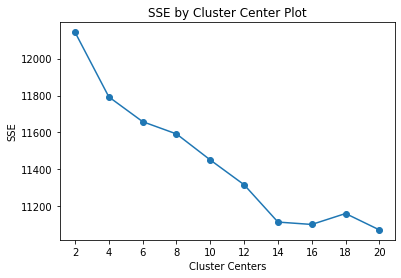

In [7]:
min_clust = 2
max_clust = 20

iters = range(min_clust, max_clust+1, 2)
    
sse = []
for k in iters:
    sse.append(
        MiniBatchKMeans(
            n_clusters=k, 
            init_size=1024, 
            batch_size=2048, 
            random_state=20
        ).fit(tfidf_matrix).inertia_
    )
    print('Fit {} clusters'.format(k))

f, ax = plt.subplots(1, 1)
ax.plot(iters, sse, marker='o')
ax.set_xlabel('Cluster Centers')
ax.set_xticks(iters)
ax.set_xticklabels(iters)
ax.set_ylabel('SSE')
ax.set_title('SSE by Cluster Center Plot')

## Plotting Obtained Clusters
We plot the clusters induced by our `K-Means` operations.

In the following, one plot uses `Principal Component Analysis` which is better at capturing the global structure of the data.

The other plot uses `T-Distributed Stochastic Neighbor Embedding` which is better at capturing relations between neighbors

In [0]:
num_clusters = 14

mbkm = MiniBatchKMeans(
    n_clusters=num_clusters, 
    init_size=1024, 
    batch_size=2048, 
    compute_labels = True,
    random_state=1695).fit(tfidf_matrix)

mbkm.predict(tfidf_matrix)

clusters = mbkm.labels_

We add to our original dataframe a new column which represent, for each document, the assigned cluster.

In [9]:
dataset['clusters'] = clusters
dataset.head()

dataset['clusters'].value_counts().sort_index()

0      539
1      172
2      471
3      436
4      174
5     3342
6      747
7     2051
8     1910
9      604
10     408
11    1564
12     426
13     243
Name: clusters, dtype: int64

## Top Keyword Extraction
Lastly, we'll cycle through the clusters and print out the top keywords based on their TF-IDF score to see if we can spot any trends. 

I'll do this by computing an average value across all dimensions in Pandas, grouped by the cluster label. 
Using numpy, finding the top words is simply sorting the average values for each row, and taking the top N.

`Topics` including exploitation of children, tax fraud, civil rights, and environmental issues can be inferred from the top keywords. 

Other interesting approaches to this might include `Latent Dirichlet Allocation` topic modeling or possibly working with pre-trained word embeddings.

In [47]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    res = {}
    for i,r in df.iterrows():
        print('\nCluster {}:'.format(i))
        s = ','.join([labels[t] for t in np.argsort(r)[-n_terms:]])
        print(s)
        res[i] = s
    return res
targets = get_top_keywords(tfidf_matrix, clusters, tfidf.get_feature_names(), 10)

colors = {0: '#1b9e77',
          1: '#d95f02',
          2: '#7570b3',
          3: '#e7298a',
          4: '#66a61e',
          5: '#808000',
          6: '#00ffff',
          7: '#00ff00',
          8: '#800080',
          9: '#ff0000',
          10: '#6e00db',
          11: '#a2a2a2',
          12: '#004b00',
          13: '#930000'}


Cluster 0:
allegations,act,services,government,medicare,false,settlement,care,claims,health

Cluster 1:
hotline,provision,status,800,citizenship,immigration,ina,employment,discrimination,osc

Cluster 2:
price,prices,estate,fine,foreclosure,fixing,rigging,bid,auctions,antitrust

Cluster 3:
card,theft,identity,attorney,district,criminal,property,counterfeit,intellectual,computer

Cluster 4:
consumer,manufacturing,supplements,complaint,dietary,products,drug,drugs,food,fda

Cluster 5:
guilty,financial,office,division,indictment,department,district,attorney,criminal,fraud

Cluster 6:
beneficiaries,home,strike,oig,services,hhs,care,fraud,health,medicare

Cluster 7:
general,crime,members,police,justice,violence,department,law,gang,attorney

Cluster 8:
revenue,attorney,division,return,refunds,false,income,irs,returns,tax

Cluster 9:
emissions,environment,settlement,pollution,oil,air,clean,water,environmental,epa

Cluster 10:
images,sexual,children,ceos,safe,project,exploitation,childhood,porn

##Plotting Obtained Clusters

We plot the clusters induced by our K-Means operations.

In the following, one plot uses `Principal Component Analysis` which is better at capturing the global structure of the data.

The other plot uses `T-Distributed Stochastic Neighbor Embedding` which is better at capturing relations between neighbors.

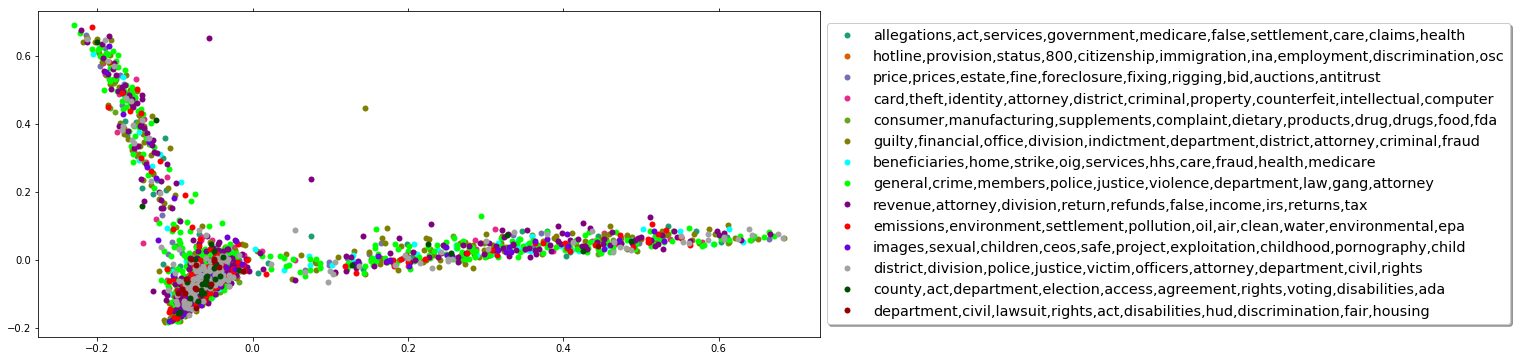

In [81]:
max_label = max(clusters)
max_items = np.random.choice(range(tfidf_matrix.shape[0]), size=3000, replace=False)

pca = PCA(n_components=2).fit_transform(tfidf_matrix[max_items,:].todense())

xs, ys = pca[:,0], pca[:,1]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters.tolist()[:3000]))

groups = df.groupby('label')

f, ax = plt.subplots(figsize=(14, 6))

for name, group in groups:
    ax.plot(
        group.x, 
        group.y, 
        marker='o', 
        linestyle='', 
        label=targets[name], 
        color=colors[name],
        mec='none'
    )

    ax.tick_params(
        axis= 'x',         
        which='both',    
        bottom='off',      
        top='off',        
        labelbottom='off')
    
    ax.tick_params(
        axis= 'y',        
        which='both',    
        left='off',      
        top='off',         
        labelleft='off')
    
ax.legend(numpoints=1, loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fancybox=True, shadow=True, fontsize='x-large')

Text(0.5, 1.0, 'TSNE Cluster Plot')

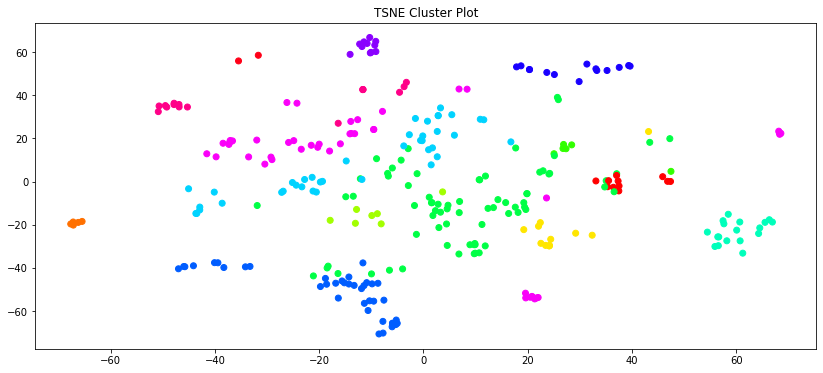

In [83]:
max_label = max(clusters)
max_items = np.random.choice(range(tfidf_matrix.shape[0]), size=3000, replace=False)

tsne = TSNE().fit_transform(
    PCA(n_components=50).fit_transform(tfidf_matrix[max_items,:].todense()))

xs, ys = tsne[:,0], tsne[:,1]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters.tolist()[:3000]))

idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
label_subset = clusters[max_items]
label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]

f, ax = plt.subplots(figsize=(14, 6))
ax.scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
ax.set_title('TSNE Cluster Plot')